# **Does Money Actually Buy Happiness?** #

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from statsmodels.stats.power import TTestPower
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix, log_loss, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, binarize, PolynomialFeatures
import statsmodels.formula.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter
import math
import warnings
warnings.filterwarnings('ignore')

## **Data Loading** ##

### Income Data ###

Let's take a look at some income data first. For each country, they are given an income index on a range from 0-10. This data was collected from [Income by Country](https://www.kaggle.com/frankmollard/income-by-country). We are assuming that the Income Index is some score derived from metrics such as (GDP, GNI, etc)

The most recent data is from 2018. We will use the 2018 data under the assumption that the most recent data is the best representation of the population today.

In [34]:
df = pd.read_csv("Income by Country.csv")
df = df[['Country','2018']]
df = df[df != '..']
df.sample(10)

,Country,2018
197,Regions,NaN
49,Dominican Republic,0.758
47,Djibouti,0.541
134,Papua New Guinea,0.545
156,Slovenia,0.872
148,Sao Tome and Principe,0.515
60,France,0.907
131,Palau,0.773
23,Brazil,0.747
106,Mali,0.45


### Happiness Data ###

We will be using data from [World Happiness Report](https://www.kaggle.com/mathurinache/world-happiness-report) to find a metric for happiness in each country. We will take data from the year 2018 so it matches our income data.

In [35]:
hf = pd.read_csv('2018.csv')
hf.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340
2,3,Denmark,7.555,1.351,1.590,0.868,0.683,0.284,0.408
3,4,Iceland,7.495,1.343,1.644,0.914,0.677,0.353,0.138
4,5,Switzerland,7.487,1.420,1.549,0.927,0.660,0.256,0.357


### Merging the Data ###

Let's merge the data so we can use our tools to compare happiness and income index. It's easier to visualize if they are in a single dataframe.

In [36]:
ff = pd.merge(left=df, right=hf, left_on='Country', right_on='Country or region')
ff.drop(columns='Country or region', inplace=True)
ff.rename(columns={'2018':'Income Index'}, inplace=True)
ff['Income Index'] = ff['Income Index'].astype(float)

In [37]:
ff.sample(10)

,Country,Income Index,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
63,Kenya,0.516,124,4.410,0.493,1.048,0.454,0.504,0.352,0.055
56,Ireland,0.955,14,6.977,1.448,1.583,0.876,0.614,0.307,0.306
16,Bosnia and Herzegovina,0.732,93,5.129,0.915,1.078,0.758,0.280,0.216,0.000
69,Liberia,0.354,149,3.495,0.076,0.858,0.267,0.419,0.206,0.030
10,Bangladesh,0.559,115,4.500,0.532,0.850,0.579,0.580,0.153,0.144
78,Mauritania,0.547,126,4.356,0.557,1.245,0.292,0.129,0.134,0.093
67,Lebanon,0.712,80,5.358,0.965,1.179,0.785,0.503,0.214,0.136
87,Nepal,0.501,101,4.880,0.425,1.228,0.539,0.526,0.302,0.078
54,Indonesia,0.714,96,5.093,0.899,1.215,0.522,0.538,0.484,0.018
110,Slovenia,0.872,51,5.948,1.219,1.506,0.856,0.633,0.160,0.051


In [38]:
ff.describe()

,Income Index,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,133.000000
mean,0.707649,77.283582,5.409746,0.898537,1.223216,0.599000,0.458112,0.181179,0.115143
std,0.183213,46.478488,1.154172,0.394071,0.303828,0.247065,0.162948,0.101273,0.099199
min,0.285000,1.000000,2.905000,0.024000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.559500,36.250000,4.435000,0.595250,1.080500,0.418750,0.356750,0.108500,0.051000
50%,0.729500,77.500000,5.404000,0.962500,1.273500,0.667500,0.497500,0.173500,0.082000
75%,0.857750,119.750000,6.297500,1.194750,1.467500,0.779750,0.580000,0.241000,0.138000
max,1.000000,156.000000,7.632000,2.096000,1.644000,1.008000,0.724000,0.598000,0.457000


### Correlation Analysis ###

Using a pairplot, we can visualize relationships between income and different features could help describe the happiness score. We can also determine if there are any huge outliers in the data.

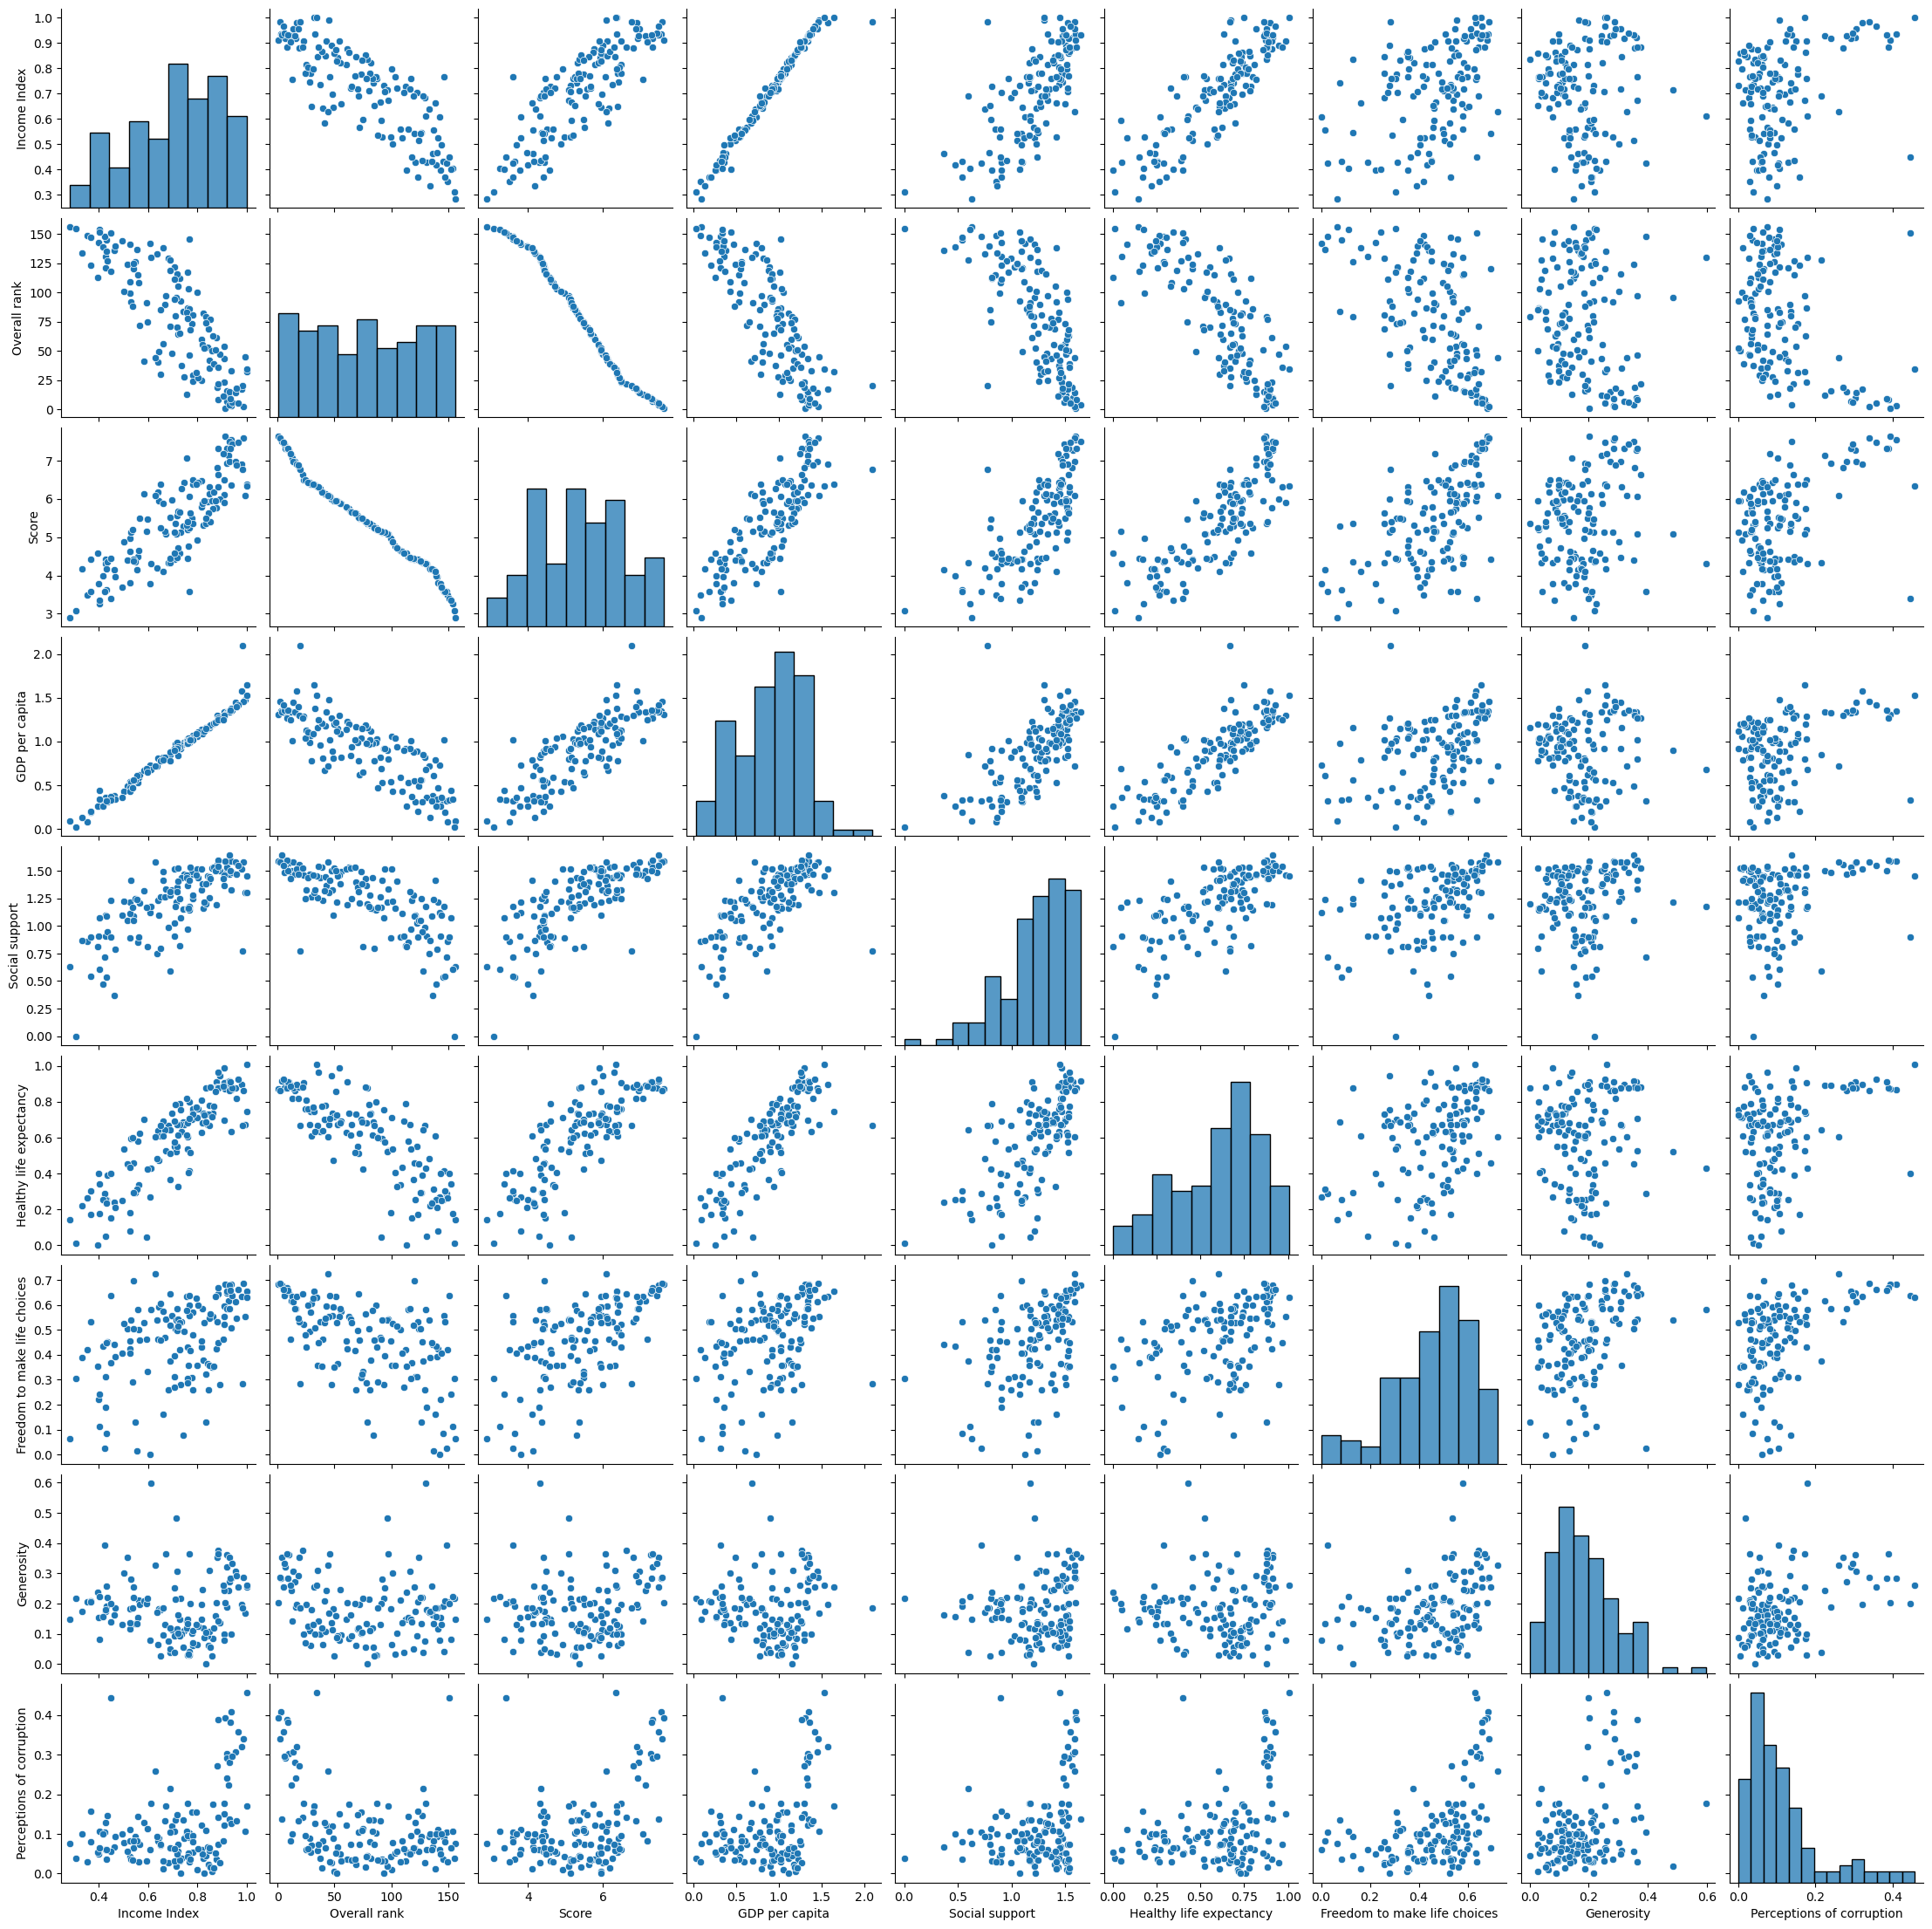

In [39]:
sns.pairplot(ff)

Outliers:

There are some stray points that look a little far from the data. However, we have decided to keep them since they could be important indicators of things that could impact happiness besides money.

Correlation Table:

Let's add a correlation table to more accurately describe the correlations we see above

In [40]:
corr = ff.corr().sort_values(by='Score')
corr.style.background_gradient()
corr.style.background_gradient().set_precision(2)

,Income Index,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Overall rank,-0.83,1.00,-0.99,-0.82,-0.74,-0.81,-0.57,-0.16,-0.43
Generosity,0.02,-0.16,0.19,0.01,0.10,0.04,0.34,1.00,0.35
Perceptions of corruption,0.37,-0.43,0.47,0.38,0.30,0.36,0.48,0.35,1.00
Freedom to make life choices,0.42,-0.57,0.58,0.39,0.46,0.44,1.00,0.34,0.48
Social support,0.73,-0.74,0.75,0.69,1.00,0.69,0.46,0.10,0.30
Healthy life expectancy,0.87,-0.81,0.81,0.84,0.69,1.00,0.44,0.04,0.36
GDP per capita,0.99,-0.82,0.82,1.00,0.69,0.84,0.39,0.01,0.38
Income Index,1.00,-0.83,0.83,0.99,0.73,0.87,0.42,0.02,0.37
Score,0.83,-0.99,1.00,0.82,0.75,0.81,0.58,0.19,0.47


What can we gather from the above table?



*   Income Index has a fairly high correlation to happiness score, social support, healthy life expectancy
*   The Happiness Score is highly correlated with GDP per capita, social support, healthy life expectancy. It has a moderate correlation to 'Freedom to make life choices'.



So what does this mean?

Features that are highly correlated to income are also highly correlated to happiness scores. This is in indicator that income (money) really is a big contributor to happiness.

### Model Creation ###

Let's create some models to see which one most accurately describes a relationship between Income and Score

First, let's split the data into x and y variables. We will exclude other features besides Income Index since we want to see how accurately we can predict Happiness with only Income alone.

Notes:


*   Since Income Index is on a scale from 0-1 and we are only using one feature to predict, it isn't necessary to use a scaler.  



In [41]:
yE = np.array(ff["Score"]).reshape(-1,1)
xE = np.array(ff['Income Index']).reshape(-1,1)
xE.shape, yE.shape

((134, 1), (134, 1))

Split the data into training and testing

In [42]:
xTrainE, xTestE, yTrainE, yTestE = train_test_split(xE,yE,random_state=42, test_size=0.33)

#### Model 1: Linear Regression ####

In [43]:
model1 = LinearRegression().fit(xTrainE, yTrainE.ravel())
yPred1 = model1.predict(xTestE)

print('R2:', model1.score(xTestE, yTestE))
print('RMSE:', mean_squared_error(yTestE, yPred1, squared=False))

R2: 0.6658948076014135
RMSE: 0.6231977631681661


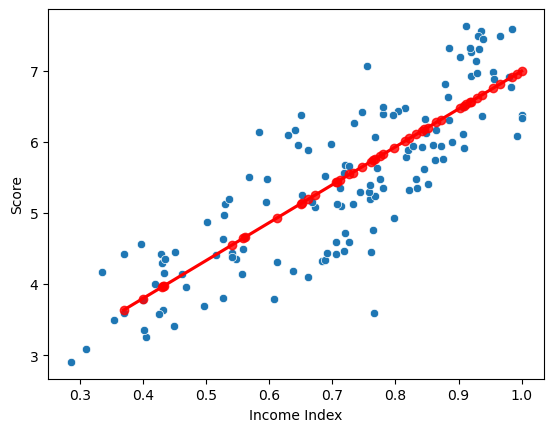

In [44]:
sns.scatterplot(x=ff['Income Index'], y=ff['Score'])
sns.regplot(x=xTestE, y=yPred1, color='Red')
plt.show()

#### Model 2: Polynomial Regression (Degree 2) ####

In [45]:
poly1 = PolynomialFeatures(degree=2)
model2 = make_pipeline(poly1, LinearRegression())
model2.fit(xTrainE,yTrainE)
yPred2 = model2.predict(xTestE)

print('R2:', model2.score(xTestE, yTestE))
print('RMSE:', mean_squared_error(yTestE, yPred2, squared=False))

R2: 0.6772399265767979
RMSE: 0.6125255036527476


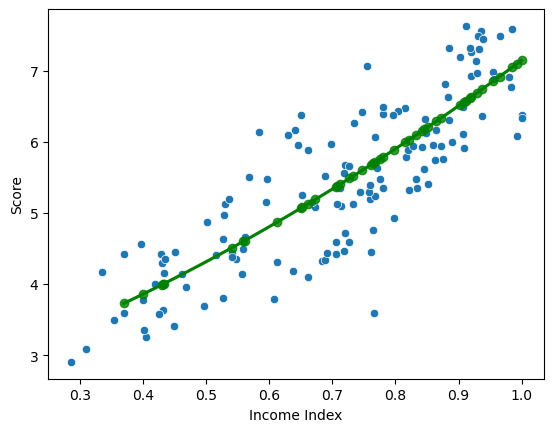

In [46]:
sns.scatterplot(x=ff['Income Index'], y=ff['Score'])
sns.regplot(x=xTestE, y=yPred2, color='Green', order=2)
plt.show()

#### Model 3: Polynomial Regression (Degree 3) ####

In [47]:
poly2 = PolynomialFeatures(degree=3)
model3 = make_pipeline(poly2, LinearRegression())
model3.fit(xTrainE,yTrainE)
yPred3 = model3.predict(xTestE)

print('R2:', model3.score(xTestE, yTestE))
print('RMSE:', mean_squared_error(yTestE, yPred3, squared=False))

R2: 0.6752790356674694
RMSE: 0.6143833495145737


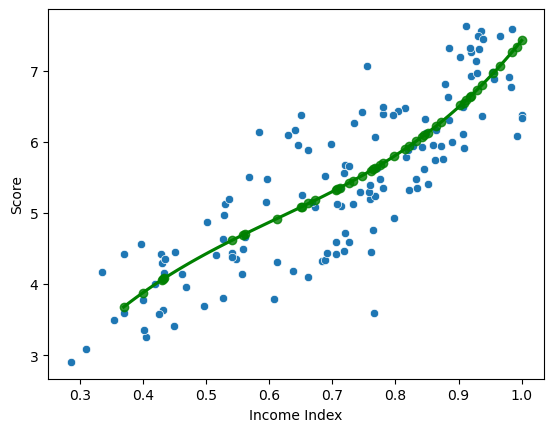

In [48]:
sns.scatterplot(x=ff['Income Index'], y=ff['Score'])
sns.regplot(x=xTestE, y=yPred3, color='Green', order=3)
plt.show()

#### Results ####

The results of models 2 and 3 are fairly similar but they're only slightly better than model 1.

The R2 values aren't too bad given that Happiness scores range from 0-10

Our predictive models both illustrate that as Income Index increases, the predicted Happiness Index increases as well. Our R2 values indicate how much of the variance in the Happiness Score is described by our models.

We can interpret that to mean the Income is a significant indicator of Happiness but there are other variables that are important to Happiness as well.

### Further Exploration ###

Let's separate into High and Low income countries and see if there is a significant difference in Happiness scores.

In [49]:
ff["IncomeBracket"] = ""
scoreCol = ff.columns.get_loc("Income Index")
IncomeCol = ff.columns.get_loc("IncomeBracket")

for i in range(len(ff)) :
    if ff.iloc[i,scoreCol] < 0.5:
        ff.iloc[i,IncomeCol] = 0
    else:
        ff.iloc[i,IncomeCol] = 1

ff.head(15)

,Country,Income Index,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,IncomeBracket
0,Afghanistan,0.432,145,3.632,0.332,0.537,0.255,0.085,0.191,0.036,0
1,Albania,0.727,112,4.586,0.916,0.817,0.790,0.419,0.149,0.032,1
2,Algeria,0.743,84,5.295,0.979,1.154,0.687,0.077,0.055,0.135,1
3,Angola,0.607,142,3.795,0.730,1.125,0.269,0.000,0.079,0.061,1
4,Argentina,0.781,29,6.388,1.073,1.468,0.744,0.570,0.062,0.054,1
5,Armenia,0.684,129,4.321,0.816,0.990,0.666,0.260,0.077,0.028,1
6,Australia,0.920,10,7.272,1.340,1.573,0.910,0.647,0.361,0.302,1
7,Austria,0.927,12,7.139,1.341,1.504,0.891,0.617,0.242,0.224,1
8,Azerbaijan,0.759,87,5.201,1.024,1.161,0.603,0.430,0.031,0.176,1
9,Bahrain,0.907,43,6.105,1.338,1.366,0.698,0.594,0.243,0.123,1


Lets visualize the difference between the two distributions.

In [50]:
ffL = ff[ff["IncomeBracket"] == 0]
ffH = ff[ff["IncomeBracket"] == 1]
ffLow = ffL.Score
ffHigh = ffH.Score

<AxesSubplot:xlabel='Score', ylabel='Density'>

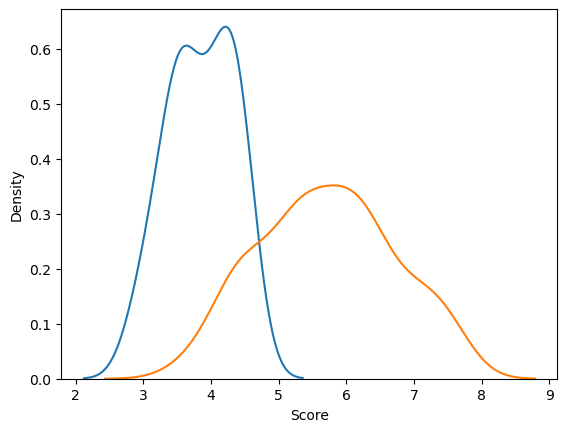

In [51]:
sns.kdeplot(ffLow)
sns.kdeplot(ffHigh)

At a glance, the distribution of High Income countries appear to have higher Happiness Scores. Both look fairly normally distributed.

In [52]:
print("Some Sample Statistics")
print()
meanLow, stdLow, varLow, nLow = ffLow.mean(), ffLow.std(), ffLow.var(), ffLow.count()
print("Low Income: ")
print(f"Mean: {meanLow}, Standard Deviation: {stdLow}, Variance: {varLow}, Count: {nLow}")
meanHigh, stdHigh, varHigh, nHigh = ffHigh.mean(), ffHigh.std(), ffHigh.var(), ffHigh.count()
print()
print("High Income:")
print(f"Mean: {meanHigh}, Standard Deviation: {stdHigh}, Variance: {varHigh}, Count: {nHigh}")

Some Sample Statistics

Low Income: 
Mean: 3.850363636363636, Standard Deviation: 0.4839947407678198, Variance: 0.2342509090909091, Count: 22

High Income:
Mean: 5.716053571428572, Standard Deviation: 0.987519094027154, Variance: 0.975193961068211, Count: 112


#### Hypothesis Test ####

In [53]:
stat1, value1 = ss.ttest_ind(ffLow, ffHigh) # Two-Tailed
stat2, value2 = ss.ttest_ind(ffHigh, ffLow, alternative='greater') # 1-Sided
print("P-Value (1-Sided):", value1)
print("P-Value (2-Sided):", value2)

P-Value (1-Sided): 1.6131058849554622e-14
P-Value (2-Sided): 8.065529424777311e-15


So it looks like there is a significant difference in happiness between our two groups. More specifically, the High income group has significantly greater Happiness scores than the Low income group

Can we trust our results?

In [54]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

In [55]:
powerTest = TTestPower()
ces = CohenEffectSize(ffLow, ffHigh)
alpha = .05
nobs = ffLow.count()+ffHigh.count() 

pow = powerTest.power(effect_size=ces, nobs=nobs, alpha=alpha)
pow

1.0

Our power test indicates that we can trust the results of our hypothesis test.

In [56]:
ff['IncomeBracket'] = ff['IncomeBracket'].astype('int64')

### Logistic Regression ###

Let's see if we can predict Income using Happiness Scores. This can give us an idea of whether the converse is true. If you're happy are you a rich person?

#### Addressing Imbalance ####

In [57]:
print(ff["IncomeBracket"].value_counts())
yS = np.array(ff["IncomeBracket"]).reshape(-1,1)
xS = np.array(ff['Score']).reshape(-1,1)

1    112
0     22
Name: IncomeBracket, dtype: int64


There are a lot more High income countries than Low. We can address this using oversampling.

In [58]:
sampler = SMOTE(n_jobs=-1)

In [59]:
xTrainS, xTestS, yTrainS, yTestS = train_test_split(xS,yS,random_state=42)

xTrainS, yTrainS = sampler.fit_resample(xTrainS, yTrainS)
print('Resampled dataset shape %s' % Counter(yTrainS))

Resampled dataset shape Counter({1: 82, 0: 82})


              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.90      0.95        30

    accuracy                           0.91        34
   macro avg       0.79      0.95      0.84        34
weighted avg       0.95      0.91      0.92        34



<AxesSubplot:>

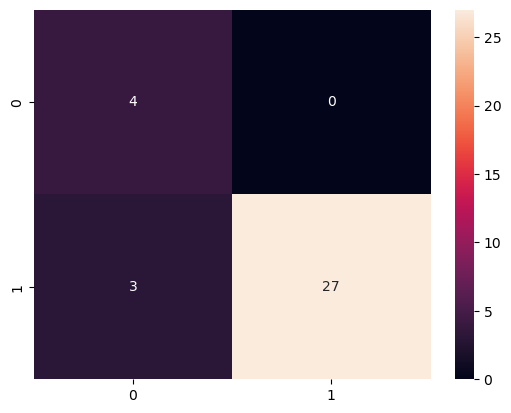

In [60]:
modelS = LogisticRegression(max_iter=1000).fit(xTrainS, yTrainS.ravel())
tmpS = modelS.predict(xTestS)
labels = binarize(np.array(tmpS).reshape(-1,1), threshold=.5)

print(classification_report(yTestS, tmpS, digits=2))

conf_matrix4 = confusion_matrix(yTestS,labels)
sns.heatmap(conf_matrix4, annot=True)

Our logistic regression did a good job at accurately identifying all the High Income countries but wrongly misclassified some countries as High Income when they were Low Income. This could be due to the fact that there aren't that many Low income countries in the test data.

Interpreting the results of the logistic regression, happiness scores are a fairly good predictor of Income.

### Conclusion ###

Our results don't show that money is the definitive source of happiness. However, most of our tests point to it being an important element of happiness.

A possible source of error is that all the members of a country are generalized into one score that describes their income and another score that describes happiness. There could be varying degrees of income and happiness within a country that aren't well-represented in the data. There is also the possibility that the happiness score doesn't fully capture how happy someone is since the criteria for happiness is different for everyone.

Another possible source of error could be in our arbitrary split of Low Income and High income countries using a cutoff of 0.5 in the Income Index column. Maybe using more categories could more accurately represent countries of Medium Income.

These criticisms aside, our analysis points us to income being a big contributor to happiness.